In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [2]:
### READ DATA ###

df = pd.read_csv('financial_data_2000_2018_cleaned.csv.zip', index_col=0)
df['timestamp'] = df.timestamp.apply(datetime.fromtimestamp)
df.sort_values(['stock','timestamp'], inplace=True)

print(df.shape)
df.head()

(168615, 7)


,stock,timestamp,open,high,low,adj_close,volume
13589,AAPL,2000-07-31,3.11,3.27,3.27,3.22,38824800
13588,AAPL,2000-08-01,3.18,3.24,3.24,3.12,34321000
13587,AAPL,2000-08-02,3.10,3.16,3.16,2.99,40588800
13586,AAPL,2000-08-03,2.88,3.04,3.04,3.04,84974400
13585,AAPL,2000-08-04,3.13,3.24,3.24,3.00,65780400


In [3]:
### CREATE OPEN PRICE MATRIX ###

df_open = df.set_index(['stock','timestamp'])['open'].unstack()
df_open = df_open.loc[~df_open.isna().any(axis=1)].copy()
df_open.columns = range(len(df_open.columns))

df_open.head()

,0,1,2,3,4,5,6,7,8,9,...,4520,4521,4522,4523,4524,4525,4526,4527,4528,4529
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,3.11,3.18,3.10,2.88,3.13,3.03,3.03,3.05,3.04,2.97,...,191.11,189.03,191.11,190.01,191.78,192.39,193.93,194.31,191.23,189.63
ADBE,27.84,29.19,28.58,27.40,28.85,29.14,30.21,30.62,29.00,27.88,...,257.86,258.00,258.17,257.66,261.04,258.35,261.92,262.05,254.42,244.93
ADSK,4.91,5.27,5.02,5.14,5.49,5.56,5.67,5.73,5.70,5.82,...,136.55,136.64,135.16,134.00,135.31,132.31,135.55,136.44,131.17,127.41
AMAT,29.46,30.25,29.32,26.01,27.97,27.06,27.92,28.75,27.94,27.01,...,48.75,47.49,46.46,46.09,46.40,45.58,45.79,48.41,48.06,48.14
AMZN,30.06,30.63,30.25,29.44,31.94,32.00,33.25,32.38,31.50,30.50,...,1848.00,1829.46,1825.01,1812.21,1829.01,1829.30,1839.00,1876.05,1827.33,1786.49


In [4]:
### CREATE HIGH PRICE MATRIX ###

df_high = df.set_index(['stock','timestamp'])['high'].unstack()
df_high = df_high.loc[~df_high.isna().any(axis=1)].copy()
df_high.columns = range(len(df_high.columns))

df_high.head()

,0,1,2,3,4,5,6,7,8,9,...,4520,4521,4522,4523,4524,4525,4526,4527,4528,4529
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,3.27,3.24,3.16,3.04,3.24,3.11,3.04,3.07,3.07,3.04,...,191.13,191.88,191.76,191.29,192.98,194.17,195.28,194.51,191.53,191.47
ADBE,28.63,29.37,29.52,28.44,29.70,30.35,30.60,30.80,29.00,29.11,...,260.94,259.60,259.45,260.14,262.73,263.50,263.83,262.86,254.76,246.80
ADSK,5.64,5.38,5.32,5.62,5.59,5.73,5.76,5.85,5.88,5.91,...,137.96,136.99,135.52,134.69,135.97,135.92,137.46,136.85,131.64,130.45
AMAT,30.42,30.32,30.40,28.26,28.07,27.87,28.16,29.24,28.73,27.45,...,48.93,47.78,46.88,46.33,47.05,45.86,47.09,49.25,48.21,48.84
AMZN,30.25,32.25,32.00,31.75,34.19,34.25,33.38,32.38,31.75,34.00,...,1858.88,1841.00,1834.84,1819.00,1840.00,1863.84,1844.68,1880.05,1829.50,1801.83


In [5]:
### CREATE CLOSE PRICE MATRIX ###

df_close = df.set_index(['stock','timestamp'])['adj_close'].unstack()
df_close = df_close.loc[~df_close.isna().any(axis=1)].copy()
df_close.columns = range(len(df_close.columns))

df_close.head()

,0,1,2,3,4,5,6,7,8,9,...,4520,4521,4522,4523,4524,4525,4526,4527,4528,4529
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,3.22,3.12,2.99,3.04,3.00,3.03,2.96,3.01,3.01,3.02,...,189.73,191.21,190.77,190.94,192.33,194.14,193.53,190.31,189.25,189.63
ADBE,28.44,28.43,28.89,28.26,29.00,30.32,30.17,28.89,28.02,28.71,...,259.78,257.68,257.54,259.47,257.49,263.17,261.93,254.81,242.32,244.68
ADSK,5.24,5.02,5.20,5.53,5.52,5.61,5.74,5.70,5.79,5.82,...,137.43,134.50,134.32,134.50,132.31,135.85,136.14,131.16,127.00,128.44
AMAT,29.79,29.27,28.48,27.08,26.59,27.45,27.70,28.31,27.18,27.16,...,48.06,46.46,46.55,46.22,45.70,45.75,46.95,48.08,47.69,48.41
AMZN,30.13,30.25,30.81,31.50,32.50,33.81,32.94,30.88,30.44,33.69,...,1842.92,1812.97,1813.70,1802.00,1829.24,1863.61,1808.00,1817.27,1779.22,1777.44


In [6]:
### UTILITY FUNCTIONS TO CREATE SEQUENCES ### 

sequence_length = 30


def get_timespan(df, today, days):
                
    date_range = np.arange(today-days, today)
                
    return df[date_range].T

def corr_matrix(df, today, days):
    
    seq = get_timespan(df, today, days)
    corr_seq = seq.corr().values
    
    return corr_seq

In [7]:
### DEFINE TRAIN/TEST SPLIT ###

train_date = int(len(df_close.columns)*0.7) 
test_date = len(df_close.columns)

In [8]:
### CREATE TRAIN SEQUENCES ###

X_seq, X_corr = [], []

for d in tqdm(range(sequence_length, train_date)):

    seq_ = np.stack([get_timespan(df_open, d, sequence_length).values,
                     get_timespan(df_high, d, sequence_length).values,
                     get_timespan(df_close, d, sequence_length).values], axis=-1)
    corr_ = corr_matrix(df_close, d, sequence_length)
    X_seq.append(seq_), X_corr.append(corr_)
    
X_train = np.stack(X_seq, axis=0).astype('float16')
X_train_corr = np.stack(X_corr, axis=0).astype('float16')

print(X_train.shape, X_train_corr.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 3141/3141 [00:12<00:00, 244.01it/s]


(3141, 30, 32, 3) (3141, 32, 32)


In [9]:
### CREATE TEST SEQUENCES ###

X_seq, X_corr = [], []

for d in tqdm(range(train_date+sequence_length, test_date)):

    seq_ = np.stack([get_timespan(df_open, d, sequence_length).values,
                     get_timespan(df_high, d, sequence_length).values,
                     get_timespan(df_close, d, sequence_length).values], axis=-1)
    corr_ = corr_matrix(df_close, d, sequence_length)
    X_seq.append(seq_), X_corr.append(corr_)
    
X_test = np.stack(X_seq, axis=0).astype('float16')
X_test_corr = np.stack(X_corr, axis=0).astype('float16')

print(X_test.shape, X_test_corr.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 1329/1329 [00:05<00:00, 250.90it/s]


(1329, 30, 32, 3) (1329, 32, 32)


In [10]:
### STANDARDIZE SEQUENCES WITH THE FIRST VALUE ###

X_train = X_train / X_train[:,0,:,:][:,None,:,:]
X_test = X_test / X_test[:,0,:,:][:,None,:,:]

In [11]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(33)
    random.seed(seed)

def get_model(series, dilation_rates, timesteps, n_features):
    
    set_seed(33)
        
    def res_block(inp, dilation_rate):

        x = Conv1D(32, 3, padding='same', dilation_rate=dilation_rate, 
                    activation='elu')(inp)
        x = Conv1D(32, 3, padding='same', dilation_rate=dilation_rate, 
                    activation='elu')(x)
        z = Conv1D(32, 3, padding='same', activation='elu')(inp)
        
        resid = Add()([z, x]) 

        return resid
    
    def wavenet(inp, dilation_rates):
    
        skips = []

        for dilation_rate in dilation_rates:
            skips.append(res_block(inp, dilation_rate))

        skips = Add()(skips)
        x = GlobalAveragePooling1D()(skips)
        
        return Model(inp, x, name='WaveNet')
    
    inp = Input((timesteps, n_features))
    WaveNet = wavenet(inp, dilation_rates)
    
    inputs, encoders = [], {}
    for s in series:
        inp = Input((timesteps, n_features), name=s)    
        encoder = WaveNet(inp)
        inputs.append(inp)
        encoders[s] = encoder
        
    dots = []
    for s1,s2 in itertools.combinations(encoders.keys(), r=2):
        dot = Dot(axes=-1, normalize=True, 
                  name=s2+'_'+s1)([encoders[s1],encoders[s2]])
        dots.append(dot)

    model = Model(inputs, dots)
    model.compile('adam', loss='mse')

    return model, WaveNet

In [12]:
### GET NUEMRICAL REFERNCES OF DESIRED STOCKS ###

id_stock = dict(enumerate(df_close.index))
stock_id = dict(zip(id_stock.values(), id_stock.keys()))

stocks = ['AAPL','AMZN','MSFT']
ids = [stock_id[s] for s in stocks]

stock_1 = stock_id['AAPL']
stock_2 = stock_id['AMZN']
stock_3 = stock_id['MSFT']

In [13]:
n_features = X_train.shape[-1]
dilation_rates = [1, 2, 4, 6, 8]

model, extractor = get_model(stocks, dilation_rates, timesteps=sequence_length, n_features=n_features)
model.fit([X_train[:,:,s,:] for s in ids], 
          [X_train_corr[:,s1,s2] for s1,s2 in itertools.combinations(ids, r=2)],
          epochs=100, batch_size=256, verbose=2)

Epoch 1/100
13/13 - 2s - loss: 1.5255 - AMZN_AAPL_loss: 0.5227 - MSFT_AAPL_loss: 0.5088 - MSFT_AMZN_loss: 0.4941
Epoch 2/100
13/13 - 2s - loss: 0.8512 - AMZN_AAPL_loss: 0.2679 - MSFT_AAPL_loss: 0.2963 - MSFT_AMZN_loss: 0.2870
Epoch 3/100
13/13 - 1s - loss: 0.6608 - AMZN_AAPL_loss: 0.2127 - MSFT_AAPL_loss: 0.2290 - MSFT_AMZN_loss: 0.2192
Epoch 4/100
13/13 - 1s - loss: 0.6076 - AMZN_AAPL_loss: 0.2017 - MSFT_AAPL_loss: 0.1998 - MSFT_AMZN_loss: 0.2061
Epoch 5/100
13/13 - 1s - loss: 0.6805 - AMZN_AAPL_loss: 0.2215 - MSFT_AAPL_loss: 0.2391 - MSFT_AMZN_loss: 0.2199
Epoch 6/100
13/13 - 1s - loss: 0.8226 - AMZN_AAPL_loss: 0.2588 - MSFT_AAPL_loss: 0.2882 - MSFT_AMZN_loss: 0.2756
Epoch 7/100
13/13 - 2s - loss: 0.5981 - AMZN_AAPL_loss: 0.1981 - MSFT_AAPL_loss: 0.1998 - MSFT_AMZN_loss: 0.2002
Epoch 8/100
13/13 - 2s - loss: 0.7669 - AMZN_AAPL_loss: 0.2481 - MSFT_AAPL_loss: 0.2576 - MSFT_AMZN_loss: 0.2612
Epoch 9/100
13/13 - 2s - loss: 1.0299 - AMZN_AAPL_loss: 0.3313 - MSFT_AAPL_loss: 0.3637 - MSFT_A

Epoch 73/100
13/13 - 3s - loss: 0.2663 - AMZN_AAPL_loss: 0.0807 - MSFT_AAPL_loss: 0.0955 - MSFT_AMZN_loss: 0.0901
Epoch 74/100
13/13 - 2s - loss: 0.2269 - AMZN_AAPL_loss: 0.0739 - MSFT_AAPL_loss: 0.0789 - MSFT_AMZN_loss: 0.0742
Epoch 75/100
13/13 - 2s - loss: 0.2660 - AMZN_AAPL_loss: 0.0825 - MSFT_AAPL_loss: 0.0963 - MSFT_AMZN_loss: 0.0873
Epoch 76/100
13/13 - 2s - loss: 0.3192 - AMZN_AAPL_loss: 0.0934 - MSFT_AAPL_loss: 0.1200 - MSFT_AMZN_loss: 0.1058
Epoch 77/100
13/13 - 2s - loss: 0.3305 - AMZN_AAPL_loss: 0.0997 - MSFT_AAPL_loss: 0.1229 - MSFT_AMZN_loss: 0.1079
Epoch 78/100
13/13 - 2s - loss: 0.5468 - AMZN_AAPL_loss: 0.1657 - MSFT_AAPL_loss: 0.2055 - MSFT_AMZN_loss: 0.1756
Epoch 79/100
13/13 - 2s - loss: 0.6575 - AMZN_AAPL_loss: 0.1913 - MSFT_AAPL_loss: 0.2478 - MSFT_AMZN_loss: 0.2185
Epoch 80/100
13/13 - 2s - loss: 0.4870 - AMZN_AAPL_loss: 0.1408 - MSFT_AAPL_loss: 0.1844 - MSFT_AMZN_loss: 0.1617
Epoch 81/100
13/13 - 2s - loss: 0.2520 - AMZN_AAPL_loss: 0.0764 - MSFT_AAPL_loss: 0.0943

In [14]:
### MAKE PREDICTION ON UNSEEN DATA ###

pred_test = model.predict([X_test[:,:,s,:] for s in ids])

In [15]:
### PERFORMANCE ON UNSEEN DATA ###

[mean_squared_error(X_test_corr[:,s1,s2],pred_test[i]) for i,(s1,s2) in enumerate(itertools.combinations(ids, r=2))]

[0.09122674, 0.1148305, 0.091267206]

In [16]:
### EXTRACT EMBEDDINGS ###

train_emb = np.concatenate([extractor.predict(X_train[:,:,s,:]) for s in ids], axis=1)
test_emb = np.concatenate([extractor.predict(X_test[:,:,s,:]) for s in ids], axis=1)

print(train_emb.shape, test_emb.shape)

(3141, 96) (1329, 96)


In [17]:
### FIT TSNE ON UNSEEN DATA ###

embedding = TSNE(n_components=2, perplexity=900, random_state=33)
components_test = embedding.fit_transform(test_emb)

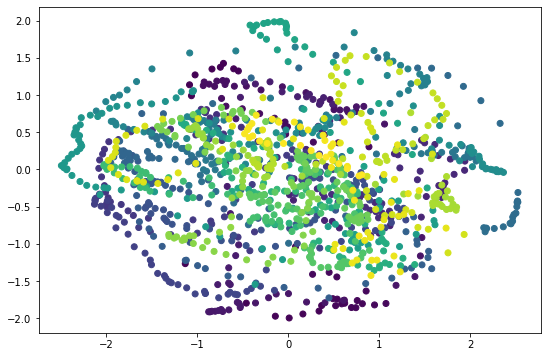

In [18]:
### EMBEDDINGS IN FUNTION OF TIME ###

plt.figure(figsize=(9,6))
plt.scatter(components_test[:,0],components_test[:,1], c=np.arange(test_date-train_date-sequence_length), cmap='viridis')

Text(0.5, 1.0, 'correlation AMZN-MSFT')

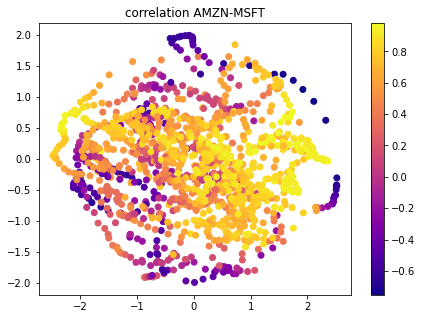

In [19]:
### EMBEDDINGS IN FUNTION OF CORR INDEX (AMZN-MSFT) ###

plt.figure(figsize=(7,5))
plt.scatter(components_test[:,0],components_test[:,1], c=X_test_corr[:,stock_2,stock_3], cmap='plasma')
plt.colorbar(); plt.title('correlation AMZN-MSFT')

Text(0.5, 1.0, 'correlation AAPL-AMZN')

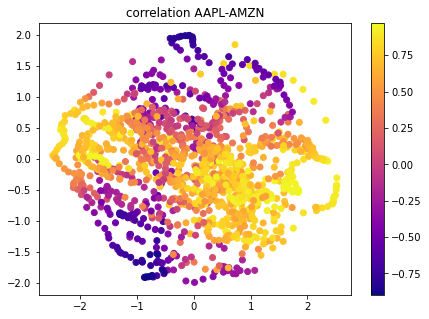

In [20]:
### EMBEDDINGS IN FUNTION OF CORR INDEX (AAPL-AMZN) ###

plt.figure(figsize=(7,5))
plt.scatter(components_test[:,0],components_test[:,1], c=X_test_corr[:,stock_1,stock_2], cmap='plasma')
plt.colorbar(); plt.title('correlation AAPL-AMZN')

Text(0.5, 1.0, 'correlation MSFT-APPL')

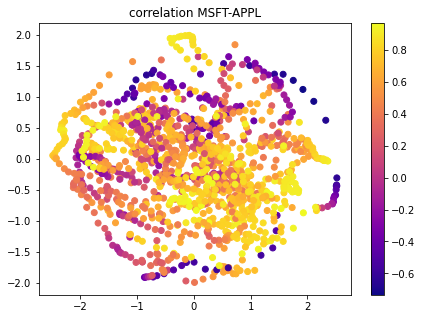

In [21]:
### EMBEDDINGS IN FUNTION OF CORR INDEX (MSFT-APPL) ###

plt.figure(figsize=(7,5))
plt.scatter(components_test[:,0],components_test[:,1], c=X_test_corr[:,stock_3,stock_1], cmap='plasma')
plt.colorbar(); plt.title('correlation MSFT-APPL')